In [68]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import libarchive
import pydot
import cartopy
import re
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical

import keras_metrics


In [69]:
data = pd.read_csv('../Desktop/a.csv')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()



(56674, 2)


,Tweet,Polarity
0,قبل ان يتحلطم عبيد الدنيا بسبب رفع_الدعم لابد...,pos
1,اكثر الساخطين على قرار رفع_اسعار_البنزين_والك...,neg
2,وبعد فتره من تطبيق رسوم_الاراضي_البيضاا سوف ي...,neut
3,اذاخسر تعادل الهلال حطوا بيضه فوق راسي وتجيكم ...,neut
4,اخطاا كثيره اليوم من لاعبي الهلال بالاخص سلمان...,neg


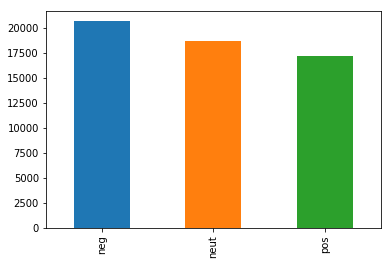

In [70]:
data['Polarity'].value_counts().sort_index().plot.bar()

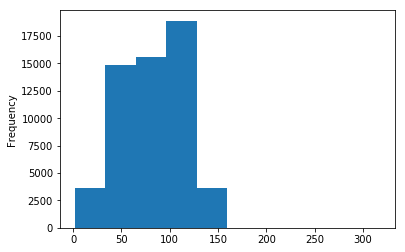

In [71]:
data['Tweet'].str.len().plot.hist()

In [72]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,قبل ان يتحلطم عبيد الدنيا بسبب رفع_الدعم لابد...,pos,1
1,اكثر الساخطين على قرار رفع_اسعار_البنزين_والك...,neg,0
2,وبعد فتره من تطبيق رسوم_الاراضي_البيضاا سوف ي...,neut,2
3,اذاخسر تعادل الهلال حطوا بيضه فوق راسي وتجيكم ...,neut,2
4,اخطاا كثيره اليوم من لاعبي الهلال بالاخص سلمان...,neg,0


In [73]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
data['clean'] = data['clean'].apply(lambda x: re.sub('(#[أ-ي]+)|(_[أ-ي]+)', '', x, flags=re.UNICODE))

#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,قبل ان يتحلطم عبيد الدنيا بسبب رفع_الدعم لابد...,pos,1,"[يتحلطم, عبيد, الدنيا, بسب, رفع, لابد, نتذكر, ..."
1,اكثر الساخطين على قرار رفع_اسعار_البنزين_والك...,neg,0,"[الساخطين, قرار, رفع, خرفان, لديهم, ارتباطات, ..."
2,وبعد فتره من تطبيق رسوم_الاراضي_البيضاا سوف ي...,neut,2,"[وبعد, فتره, تطبيق, رسوم, يتمكن, باءع, الارض, ..."
3,اذاخسر تعادل الهلال حطوا بيضه فوق راسي وتجيكم ...,neut,2,"[اذاخسر, تعادل, الهلال, حطوا, بيضه, راسي, وتجي..."
4,اخطاا كثيره اليوم من لاعبي الهلال بالاخص سلمان...,neg,0,"[اخطا, كثيره, لاعبي, الهلال, بالاخص, سلمان, ال..."
5,والله لو كان سكان غزه من غير المسلمين بل لو ك...,neut,2,"[واله, سكان, غزه, المسلمين, كانوا, ليسوا, البش..."
6,رفع_اسعار_البنزين_والكهرباا ي حسرتي ي وجودي م...,neg,0,"[رفع, حسرتي, وجودي, ماعاد, فره]"
7,الحمدلله على عطائه الحمدلله على نعمه التي لا ...,pos,1,"[الحمدله, عطاءه, الحمدله, نعمه, تعد, تحصي, غير..."
8,ابطالنا يسطرون الملاحم بشجاعه وبساله اللهم ثب...,pos,1,"[ابطالنا, يسطرون, الملاحم, بشجاعه, وبساله, اله..."
9,الحين ليش تغردون اصلا انا غايب غايب تعليق_الدر...,neut,2,"[الحين, ليش, تغردون, اصلا, انا, غايب, غايب, تع..."


In [74]:
CBOW = Word2Vec.load('../Desktop/aravecuni/full_uni_cbow_100_twitter.mdl')
CBOWE = CBOW.wv.get_keras_embedding()

In [75]:
# def buildWordVector(tokens, size):
#     vec = np.zeros(size).reshape((1, size))
#     count = 0.
#     for word in tokens:
#         try:
#             vec += CBOW[word].reshape((1, size))
#             count += 1.
#         except KeyError: # handling the case where the token is not
#             continue
#     if count != 0:
#         vec /= count
#     return vec

# X_train = np.concatenate([buildWordVector(x, 100) for x in data['clean']])
# X_train.shape

In [39]:
y = to_categorical(data['Sentiment'].values)

In [40]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   761,  6231, 35366,  3894,  9821,    46],
       [    0,     0,     0,     0,     0,     0,     0,     0, 18406,
        18407, 14922,  8799, 18408, 18409, 14923, 18410, 18411, 18412,
        12770,  1725, 14924,  3713, 12771, 18413, 18414],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,  1122,     1, 35367],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    94,   194,  1086,   443,   762,     1, 12772,
         7952, 14925,   186, 23980,   970, 18415,     1],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     1,   120,    60,
         3530,   278,  1024,   537,  3530, 12773,  1024]])

In [41]:
X.shape

(56674, 25)

## Prepare metrics

In [42]:
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
# metrics
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

Instructions for updating:
Colocations handled automatically by placer.


In [65]:
# hyperparamters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.3
EPOCHS = 10

#  Build the models

## Stacked-LSTM

In [45]:
%time
lstm_model_input = layers.Input(shape=(X.shape[1],))
x = CBOWE(lstm_model_input)
x = layers.LSTM(100, return_sequences=True)(x)
x = layers.LSTM(100, return_sequences=False)(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(3, activation='softmax')(x)
lstm_model = keras.models.Model(inputs=lstm_model_input, outputs=x)

lstm_model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.Adam(lr=LEARNING_RATE),
                   metrics=metrics,)
lstm_model.fit(X, y, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS)

Wall time: 0 ns
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 39671 samples, validate on 17003 samples
Epoch 1/10
39671/39671 [==============================] - 44s 1ms/step - loss: 0.8554 - acc: 0.6051 - precision: 0.6583 - recall: 0.4768 - f1: 0.5343 - val_loss: 0.7496 - val_acc: 0.6734 - val_precision: 0.6735 - val_recall: 0.6752 - val_f1: 0.644029 - precision: 0.6564 - recall: 
Epoch 2/10
39671/39671 [==============================] - 43s 1ms/step - loss: 0.6630 - acc: 0.7232 - precision: 0.7476 - recall: 0.6747 - f1: 0.7067 - val_loss: 0.6966 - val_acc: 0.7045 - val_precision: 0.7174 - val_recall: 0.6721 - val_f1: 0.6893
Epoch 3/10
39671/39671 [==============================] - 44s 1ms/step - loss: 0.5639 - acc: 0.7715 - precision: 0.7932 - recall: 0.7365 - f1: 0.7625 - val_loss: 0.7111 - val_acc: 0.7105 - val_precision: 0.7032 - val_recall: 0.7276 - val_f1

In [47]:
lstm_model.save('../Desktop/stacked-lstm-1')

In [48]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 100)           125975600 
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 100)           80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 126,136,703
Trainable params: 161,103
Non-trainable params: 125,975,600
________________________________________________________

In [66]:
data()

TypeError: 'DataFrame' object is not callable

## Stacked-GRU

In [67]:
%time
gru_model_input = layers.Input(shape=(X.shape[1],))
x = CBOWE(gru_model_input)
x = layers.GRU(100, return_sequences=True)(x)
x = layers.GRU(100, return_sequences=False)(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(3, activation='softmax')(x)
gru_model = keras.models.Model(inputs=gru_model_input, outputs=x)

gru_model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.Adam(lr=LEARNING_RATE),
                   metrics=metrics,)
gru_model.fit(X, y, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS)


Wall time: 0 ns


ValueError: When feeding symbolic tensors to a model, we expect thetensors to have a static batch size. Got tensor with shape: (None, 3)

In [60]:
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      multiple                  125975600 
_________________________________________________________________
gru_18 (GRU)                 (None, 25, 100)           60300     
_________________________________________________________________
gru_19 (GRU)                 (None, 100)               60300     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 126,096,503
Trainable params: 120,903
Non-trainable params: 125,975,600
________________________________________________________

In [ ]:
gru_model.save('../Desktop/stacked-gru-1')